In [157]:
# !pip install seaborn

In [158]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
import torch.nn.functional as F
from transformers import BertConfig, BertTokenizer
from transformers import logging

def get_vlnbert_models(config=None):
    config_class = BertConfig
    from src.vlnbert.vlnbert_PREVALENT import VLNBert
    model_class = VLNBert
    model_name_or_path = '/home/prj21/fyp/Recurrent-VLN-BERT-Isaac/pretrained_weight/pytorch_model.bin'
    vis_config = config_class.from_pretrained('bert-base-uncased')
    # vis_config.img_feature_dim = 2176 # Original model dim
    vis_config.img_feature_dim = 4096
    vis_config.img_feature_type = ""
    vis_config.vl_layers = 4
    vis_config.la_layers = 9
    logging.set_verbosity_error()
    visual_model = model_class.from_pretrained(model_name_or_path, config=vis_config, ignore_mismatched_sizes=True) # The mismatched visn_fc.weight -> randomly initialized values -> fine-tuned during training to adapt to the new 4096-dimensional input features.

    return visual_model
# from src.param import args

def pad_instr_tokens(instr_tokens, maxlength=20):

    if len(instr_tokens) <= 2: #assert len(raw_instr_tokens) > 2
        return None

    if len(instr_tokens) > maxlength - 2: # -2 for [CLS] and [SEP]
        instr_tokens = instr_tokens[:(maxlength-2)]

    instr_tokens = ['[CLS]'] + instr_tokens + ['[SEP]']
    num_words = len(instr_tokens)  # - 1  # include [SEP]
    instr_tokens += ['[PAD]'] * (maxlength-len(instr_tokens))

    assert len(instr_tokens) == maxlength

    return instr_tokens, num_words

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [159]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load model
model = get_vlnbert_models().to(device)
# checkpoint_path = "/home/prj21/fyp/Recurrent-VLN-BERT-Isaac/checkpoints/navigation_PREVALENT/2025-03-07_20-02-28/best_model.pt"  # Adjust path as needed
checkpoint_path = "/home/prj21/fyp/Recurrent-VLN-BERT-Isaac/checkpoints/navigation_PREVALENT/2025-03-07_20-02-28/checkpoint_100.pt"  # Adjust path as needed
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print("Model loaded successfully.")

/home/prj21/miniconda3/envs/isaaclab/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prj21/miniconda3/envs/isaaclab/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully.


In [160]:
# Define feature directory
feature_dir = "../VLN-Go2-Matterport"

# List available episodes
episode_dir = os.path.join(feature_dir, "training_data")
episodes = [e for e in os.listdir(episode_dir) if os.path.isdir(os.path.join(episode_dir, e))]
print(f"Found {len(episodes)} episodes. Selecting the first one for inspection.")

Found 869 episodes. Selecting the first one for inspection.


In [161]:
# RGB transform
rgb_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Depth transform
def depth_transform(depth):
    depth = np.where(np.isfinite(depth), depth, 1.94)  # Replace NaN/inf with max depth
    depth = torch.from_numpy(depth).float()
    depth = (depth - 1.94) / 1.43  # Standardize based on dataset stats
    depth = depth.unsqueeze(0).unsqueeze(0)
    depth = F.interpolate(depth, size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
    return depth

In [162]:
import random

In [163]:
# 689

index:  532
Selected episode: 2025-03-04_16-09-55_scene_zsNo4HB9uLZ_episode_810
Instruction: Go do the hall, and go left. Take the right before you enter the entry way, and go straight. Stop once you are on the rug, behind the desk chair.
Number of steps: 52
Ground truth actions: ['Move forward', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Turn right', 'Move forward', 'Turn right', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Turn right', 'Turn right', 'Turn right', 'Move forward', 'Turn right', 'Turn right', 'Move forward', 'Turn right', 'Turn right', 'Move forward', 'Turn right', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Turn right', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Turn right', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Move forward', 'Move 

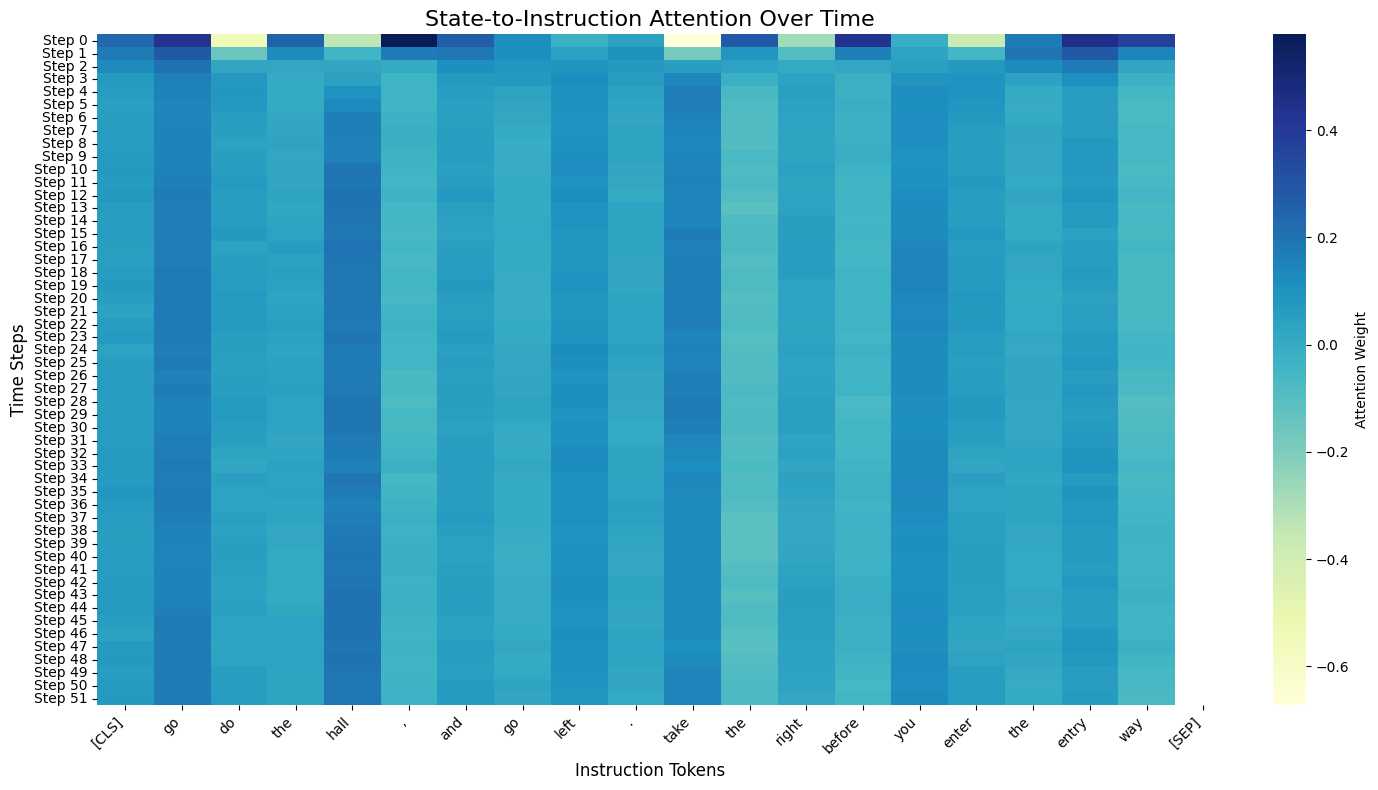

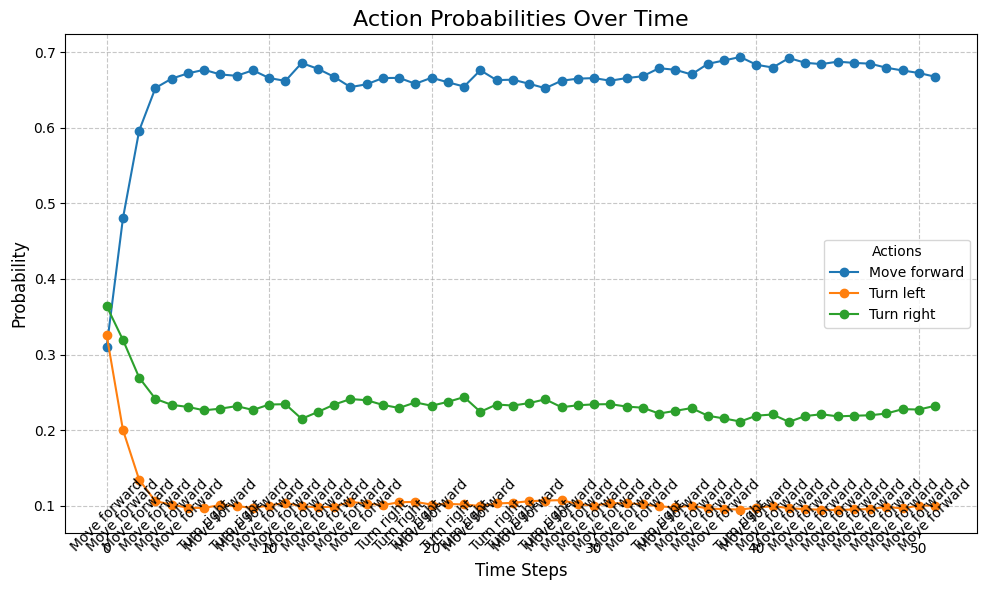

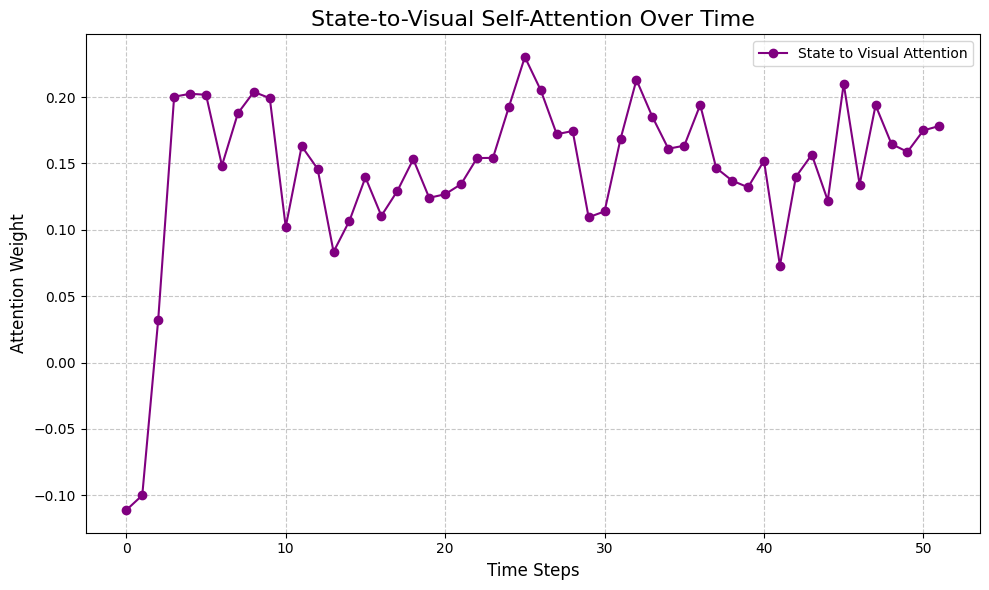

In [164]:
epidx = random.randint(0, 1000)
# epidx = 239
print("index: ", epidx)

episode_name = episodes[epidx]
# Select the first episode
# episode_name = episodes[3]  # e.g., "2025-03-04_22-48-51_scene_QUCTc6BB5sX_episode_1053"
episode_path = os.path.join(episode_dir, episode_name)
print(f"Selected episode: {episode_name}")
# Load episode data
with open(os.path.join(episode_path, "instructions.txt")) as f:
    instruction = f.read().strip()
rgb_paths = sorted([os.path.join(episode_path, "rgbs", f) for f in os.listdir(os.path.join(episode_path, "rgbs")) if f.endswith(".png")])
depth_paths = sorted([os.path.join(episode_path, "depths", f) for f in os.listdir(os.path.join(episode_path, "depths")) if f.endswith(".npy")])
with open(os.path.join(episode_path, "actions.txt")) as f:
    gt_actions = [line.strip() for line in f.readlines()]

print(f"Instruction: {instruction}")
print(f"Number of steps: {len(rgb_paths)}")
print(f"Ground truth actions: {gt_actions}")
# Tokenize and encode instruction
instr_tokens = tokenizer.tokenize(instruction)
padded_tokens, _ = pad_instr_tokens(instr_tokens, 20)
instr_encoding = tokenizer.convert_tokens_to_ids(padded_tokens)
instr_encoding = torch.tensor(instr_encoding, dtype=torch.long).unsqueeze(0).to(device)
lang_mask = (instr_encoding != tokenizer.pad_token_id).float().to(device)

print(f"Instruction tokens: {padded_tokens[:10]}... (total length: {len(padded_tokens)})")
# Lists to store attention scores
cross_attention_scores_list = []
vis_self_attention_scores_list = []

# Hook functions
def cross_hook(module, input, output):
    cross_attention_scores_list.append(output[1].detach().cpu())

def vis_self_hook(module, input, output):
    vis_self_attention_scores_list.append(output[1].detach().cpu())

# Register hooks on the last LXRTXLayer
cross_handle = model.addlayer[-1].visual_attention.register_forward_hook(cross_hook)
vis_self_handle = model.addlayer[-1].visn_self_att.register_forward_hook(vis_self_hook)
print("Hooks registered for attention scores.")
action_probs_list = []

with torch.no_grad():
    pooled_output, lang_output = model("language", input_ids=instr_encoding, lang_mask=lang_mask)

for t in range(len(rgb_paths)):
    rgb = rgb_transform(Image.open(rgb_paths[t])).unsqueeze(0).to(device)
    depth = depth_transform(np.load(depth_paths[t])).unsqueeze(0).to(device)
    vis_mask = torch.ones(1, 1).to(device)
    
    with torch.no_grad():
        pooled_output, action_logits, next_lang_output = model("visual", lang_output, lang_mask=lang_mask, vis_mask=vis_mask, rgb=rgb, depth=depth)
    
    action_probs = F.softmax(action_logits, dim=-1).squeeze(0).cpu().numpy()
    action_probs_list.append(action_probs)
    
    lang_output = next_lang_output

# Remove hooks
cross_handle.remove()
vis_self_handle.remove()
print(f"Processed {len(rgb_paths)} steps.")
# Process cross-attention scores (state to instruction)
seq_len = instr_encoding.size(1)
T = len(rgb_paths)
state_to_instr_attention = []
for scores in cross_attention_scores_list:
    attn = scores.mean(dim=1).squeeze(0)  # Average over heads: (2, seq_len)
    state_to_instr_attention.append(attn[0].numpy())  # State token attention: (seq_len,)

state_to_instr_attention = np.stack(state_to_instr_attention)  # (T, seq_len)

# Process visual self-attention scores
vis_self_attention = []
for scores in vis_self_attention_scores_list:
    attn = scores.mean(dim=1).squeeze(0)  # (2, 2)
    vis_self_attention.append(attn[0, 1].numpy())  # State to visual attention

vis_self_attention = np.array(vis_self_attention)  # (T,)
# Plot attention heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(state_to_instr_attention, cmap="YlGnBu", 
            xticklabels=tokenizer.convert_ids_to_tokens(instr_encoding[0].cpu().numpy()),
            yticklabels=[f"Step {i}" for i in range(T)],
            cbar_kws={'label': 'Attention Weight'})
plt.title("State-to-Instruction Attention Over Time", fontsize=16)
plt.xlabel("Instruction Tokens", fontsize=12)
plt.ylabel("Time Steps", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Stack action probabilities
action_probs = np.stack(action_probs_list)  # (T, 3)
actions = ["Move forward", "Turn left", "Turn right"]

# Plot
plt.figure(figsize=(10, 6))
for i, action in enumerate(actions):
    plt.plot(action_probs[:, i], label=action, marker='o')
plt.title("Action Probabilities Over Time", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.legend(title="Actions")
plt.grid(True, linestyle='--', alpha=0.7)
if gt_actions:
    for t, action in enumerate(gt_actions):
        plt.text(t, 0.04, action, rotation=45, ha='center', color='black')
plt.tight_layout()
plt.show()

# Plot state-to-visual attention
plt.figure(figsize=(10, 6))
plt.plot(vis_self_attention, label="State to Visual Attention", marker='o', color='purple')
plt.title("State-to-Visual Self-Attention Over Time", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Attention Weight", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()